In [1]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [2]:
# Below path contains all the images
from PIL import Image
import glob
images = '/content/drive/MyDrive/PDD_Data/train/0/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.JPG')
print(img[1])

/content/drive/MyDrive/PDD_Data/train/0/a5071b8f-33f8-464f-8e3f-0bcfda3d91a8.JPG


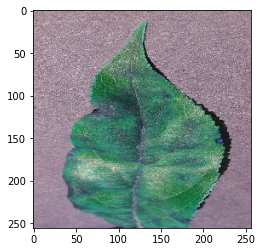

In [3]:
import matplotlib.pyplot as plt
import cv2
img = cv2.imread('/content/drive/MyDrive/PDD_Data/train/0/00b9027b-5503-4be0-b8cc-ae6796c422b6.JPG')
#resized = cv2.resize(img,(25,128), interpolation = cv2.INTER_AREA)
#print(.shape)
plt.imshow(img)
plt.show()

In [4]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense,Dropout,Activation,Flatten,BatchNormalization,AveragePooling2D,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.layers import Conv2D,MaxPooling2D
import os
import cv2
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [6]:
num_classes=38
img_rows,img_cols=256,256
batch_size=32

In [7]:
train_data_dir = '/content/drive/MyDrive/PDD_Data/train'
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    shear_range=0.3,
                    zoom_range=0.3,
                    width_shift_range=0.4,
                    height_shift_range=0.4,
                    horizontal_flip=True,
                    fill_mode='nearest')

In [8]:
validation_data_dir= '/content/drive/MyDrive/PDD_Data/test'
validation_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
                  train_data_dir,
                  target_size=(img_rows,img_cols),
                  batch_size=batch_size,
                  class_mode='categorical',
                  shuffle=True
)

Found 8751 images belonging to 38 classes.


In [10]:
validation_generator = validation_datagen.flow_from_directory(
                       validation_data_dir,
                       target_size=(img_rows,img_cols),
                       batch_size=batch_size,
                       class_mode='categorical',
                       shuffle=True)

Found 10547 images belonging to 38 classes.


In [11]:
model = keras.applications.xception.Xception(include_top=False,weights = 'imagenet')
input = Input(shape=(256,256,3))
out = model(input)
X = MaxPooling2D(pool_size=(2,2))(out)
X = Conv2D(64,(3,3),strides = (1,1),padding='same')(X)
X = BatchNormalization(axis=-1)(X)
X = Activation('relu')(X)
X = AveragePooling2D(pool_size = (2,2))(X)

X = Flatten()(X)
X = Dense(256,activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(256,activation = 'relu')(X)
preds = Dense(38,activation = 'softmax')(X)
my_model = Model(inputs = input,outputs = preds)

83689472/83683744 [==============================] - 1s 0us/step


In [12]:
for layer in model.layers[:75]:
  layer.trainable=False

In [13]:
my_model.summary()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 2048)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 64)          1179712   
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 64)          256       
_________________________________________________________________
activation (Activation)      (None, 4, 4, 64)          0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 2, 2, 64)          0     

In [14]:
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [15]:
checkpoint = ModelCheckpoint('Plant_disease.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

In [16]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

In [18]:
callbacks = [earlystop,checkpoint,reduce_lr]

In [19]:
my_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [20]:
nb_train_samples =  8751
nb_validation_samples = 10547
epochs=25

In [ ]:
history = my_model.fit(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              callbacks=callbacks,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size,
                              verbose=1)

Epoch 1/25
273/273 [==============================] - ETA: 0s - loss: 1.4926 - accuracy: 0.5716 